# Advanced Machine Learning - programming assignment 3

*Due: Friday January 10*

*Grading: 10 points total*

**Please fill in:**
* Juan David Liut Aymar - 3478092
* Alexia Ntantouri - 2958481

### Further instructions:
* Code quality is considered during the assessment. Use sensible variable names, and make sure your code is properly commented.
* Submit your code in Blackboard using one of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name. (`submitter_collaborator.ipynb`)
* **Failure to follow these instructions can affect the assignment grade.**

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [ ]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# The following three functions implement the structural equations of an SCM with three
# endogenous variables X, Y, and Z. Each endogenous variable in this SCM has one exogenous
# parent (unnamed) whose value is sampled by the corresponding function. Each of these
# functions operates on numpy arrays of length num_samples, where num_samples is the
# number of data points.
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)

# Generate data from the observational distribution.
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

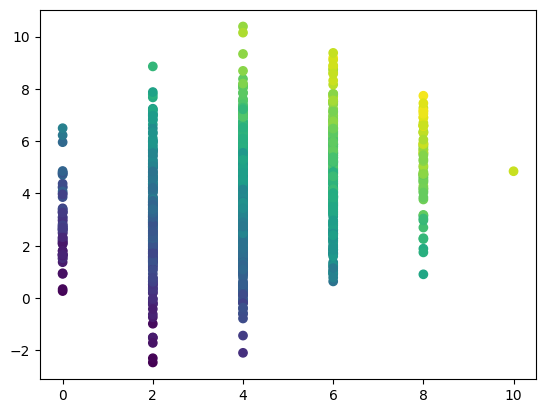

In [ ]:
plt.scatter(x, y, c=z)
plt.show()

**Task 1 (1 point):** Use any supervised learning method of your choice to fit a function from $X$ to $Y$ to these data. (So $X$ is the only feature; $Z$ is not used. Note that you are *not* asked to validate or test your fit here.) Make a new plot that displays both the data points and your fitted function, for $x$ in the range $[0,10]$.


To plot a regression curve, first use a function like `np.linspace` to create an array of neatly ordered x-values. Then have your trained machine learning model predict the y-values corresponding to those x-values.

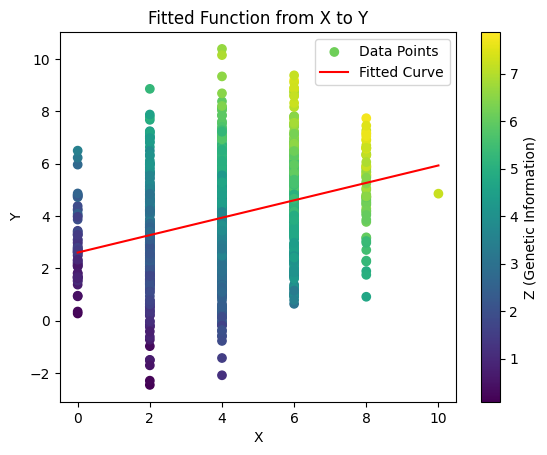

In [ ]:
# Your code here

# Import the necessary library for linear regression
from sklearn.linear_model import LinearRegression

# Reshape x for fitting into the model as it requires a 2D array for the features
x_reshaped = x.reshape(-1, 1)

# Initialize and fit the linear regression model
reg_model = LinearRegression()
reg_model.fit(x_reshaped, y)

# Create an array of x-values in the range [0, 10] for plotting the regression curve
x_range = np.linspace(0, 10, 100).reshape(-1, 1)

# Predict the corresponding y-values using the trained model
y_pred = reg_model.predict(x_range)

# Plot the original data points and the fitted regression curve
plt.scatter(x, y, c=z, cmap='viridis', label='Data Points')
plt.plot(x_range, y_pred, color='red', label='Fitted Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitted Function from X to Y')
plt.colorbar(label='Z (Genetic Information)')
plt.legend()
plt.show()


Look at the code of `f_X`, `f_Y`, `f_Z`, and `generate_observational_data` to answer the following questions.

**Question 2 (1 point):** For each endogenous variable, what other endogenous variables are the direct causes? For each such relation between two variables, explain what the presence of this relation means in the real world, where the three variables represent treatment, outcome, and genetic information.

### **1. Z: Genetic Information**

**Direct Causes:** None.

**Explanation:**
$Z$ is generated solely by exogenous noise (randomness) in the function `f_Z`.

In the real world, this means that genetic information ($Z$) is not influenced by other variables in this system. It is an inherent trait of the patient, independent of drug dosage ($X$) or recovery outcome ($Y$).

### **2. X: Drug Dosage**

**Direct Causes:** $Z$ (genetic information).

**Explanation:**
In `f_X`, $X$ is generated as a function of $Z$ with added noise:

<h5><center>$X_{continuous}=Z+Noise$</center>

This continuous value is then rounded to the nearest multiple of 2 and clipped to lie within the range [0,10], ensuring $X$ stays realistic for a dosage variable. $X$ ends up as discrete integers in $\{0,2,4,…,10\}$.

In the real world, genetic information ($Z$) influences the dosage of the drug ($X$).

This could represent a scenario where a doctor determines the drug dosage based on the patient's genetic predisposition, which may affect how they metabolize or respond to the drug.

The noise reflects variability in the dosage due to other unmeasured factors (e.g., doctor's judgment, patient's weight, etc.).

### **3. Y: Recovery Score**

**Direct Causes:** $Z$ (genetic information) and $X$ (drug dosage).

**Explanation:**
In `f_Y`, $Y$ is generated as:

<h5><center>$Y=2Z-X+Noise$</center>

In the real world, genetic information ($Z$) influences recovery directly. For example, some genes may enhance recovery, resistance to disease, or drug efficacy.

Drug dosage ($X$) also affects recovery, but the influence is negative in this model. This could reflect an adverse side effect of high dosages or overmedication.

Noise reflects the variability in recovery due to unmeasured factors (e.g., environment, nutrition, or other health conditions).

### **Table summary**

| Endogenous Variable | Direct Causes | Real-World Interpretation |
|---|---|---|
| Z | None | Genetic information is intrinsic to the patient and unaffected by other engogenous variables. |
| X | Z | Drug dosage is determined partly by genetic information, simulating personalized treatment decisions. |
| Y | Z, X | Recovery is influenced by genetic predisposition and drug dosage, with genetic factors playing a positive role. |

## Intervening on the system

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug.

**Task 3 (1 point):** Complete the following function, which is analogous to the function `generate_observational_data`, except now instead of observational data, each data point $(x_i, y_i, z_i)$ should be generated from the interventional distribution with $do(X=x_i)$. The values $x_i$ are specified by the array `x`, which is the first argument of this function.

In [ ]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.

    # Your code here

    # Generate Z independently
    z = f_Z(num_samples)

    # Use the given x values directly (intervention: do(X=x))
    # Here, x is already provided, so no modification is needed.
    x_intervened = x

    # Compute Y using the structural equation, given the intervened X and generated Z
    y = f_Y(z, x_intervened, num_samples)

    # Return the interventional data
    return (x_intervened, y, z)

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set $\{0,2,4,8\}$, independently for each individual.

In [ ]:
num_samples_exp = 200

# Set the values of x according to the distribution specified above, then generate the whole data
# under the intervention do(X=x).
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

**Task 4 (0.5 points):** Plot these experimental data in the same way as before, again including the curve you fit earlier to the observational data.

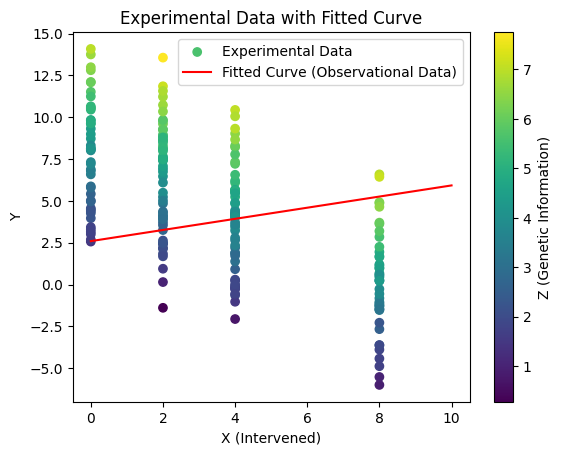

In [ ]:
# Your code here

# Generate interventional data
num_samples_exp = 200

# Set X values uniformly at random from {0, 2, 4, 8}
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)

# Generate data under the intervention do(X=x)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

# Plot the experimental data
plt.scatter(x_exp, y_exp, c=z_exp, cmap='viridis', label='Experimental Data')

# Plot the fitted regression curve from observational data
plt.plot(x_range, y_pred, color='red', label='Fitted Curve (Observational Data)')

# Add labels, title, and legend
plt.xlabel('X (Intervened)')
plt.ylabel('Y')
plt.title('Experimental Data with Fitted Curve')
plt.legend()
plt.colorbar(label='Z (Genetic Information)')
plt.show()


**Task 5 (0.5 points):** Compute the RMSE (root mean squared error) when you use the regression curve you learned earlier to predict $Y$ in these new data. (To put it another way: we used the observational data as training data, and now we are using the experimental data as test data.)

In [ ]:
# Your code here

from sklearn.metrics import mean_squared_error

# Predict Y for the experimental X values using the regression model
y_pred_exp = reg_model.predict(x_exp.reshape(-1, 1))

# Compute the RMSE
rmse = np.sqrt(mean_squared_error(y_exp, y_pred_exp))

# Print the RMSE
print(f"RMSE on experimental data: {rmse}")


RMSE on experimental data: 4.9295589191145766


You should see in your plot that the curve we learned from the observational data, does not seem to work well for predicting the outcome $Y$ in the interventional data. This is because the experimental distribution is different from the observational distribution.

**Question 6 (1 point):**

**a.** Look at the product decompositions of the original SCM and the SCM modified by the intervention on $X$. Which factors in the decompositions are the same between the observational and the experimental distribution?

**b.** For the curve you fit on the observational data to also fit well on the experimental data, a certain conditional distribution would have had to be the same for both datasets. Which conditional distribution is that? (It may or may not appear in either product decomposition.) Explain your answer.

## Part (a): Product Decompositions

### **1.Observational Distribution**

The observational distribution $P(X,Y,Z)$ can be decomposed as:

<h5> <center> $P(X,Y,Z)=P(Z)⋅P(X|Z)⋅P(Y|X,Z)$ </center>

- $P(Z):$ The marginal distribution of genetic information ($Z$).

- $P(X|Z):$ The distribution of drug dosage ($X$) conditioned on genetic information ($Z$).

- $P(Y|X,Z):$ The distribution of the outcome ($Y$) conditioned on both the drug dosage ($X$) and genetic information ($Z$).

### **2. Interventional Distribution (do(X))**

Under the intervention $do(X=x)$, the distribution becomes:

<h5> <center> $P(X,Y,Z)=P(Z)⋅P(X)⋅P(Y|X,Z)$ </center>

- $P(Z):$ Remains the same as in the observational distribution because $Z$ is unaffected by the intervention.

- $P(X)$: This is now determined by the intervention (e.g., $X$ is sampled uniformly from $\{0,2,4,8\}$), breaking the dependency between $X$ and $Z$.

- $P(Y|X,Z):$ Remains the same because the structural equation for $Y$ does not change under the intervention.

### **Factors that Remain the Same:**

$P(Z):$ The distribution of $Z$ is unchanged.

$P(Y∣X,Z):$ The causal relationship between $Y$, $X$, and $Z$ remains the same because the structural equation for $Y$ is not altered by the intervention.



## Part (b): Conditional Distribution for Good Fit

For the curve learned on observational data to also fit well on the experimental data, the conditional distribution:

$P(Y|X)$ would need to be the same in both datasets.

### **Reasoning:**

- In the observational setting, the regression curve fits $P(Y|X)$, which is effectively marginalized over $Z$:
<h5> <center> $P(Y|X)=∫P(Y|X,Z)⋅P(Z|X)dZ$ </center>

- In the experimental setting, $P(Y|X)$ becomes:
<h5> <center> $P(Y|X)=∫P(Y|X,Z)⋅P(Z)dZ$ </center>
because the intervention $do(X=x)$ breaks the dependency between $X$ and $Z$, replacing $P(Z|X)$ with $P(Z)$.

If $P(Z|X)$ in the observational data equals $P(Z)$, then $P(Y|X)$ would remain unchanged, and the observational model would generalize perfectly to the experimental setting.

### **Why This Doesn't Hold:**

- In the observational data, $P(Z|X)$ is influenced by the structural dependency $X∼f_{X}(Z)$.

- In the experimental data, $P(Z|X)$ is replaced by $P(Z)$, breaking the original dependency.

Consequently, $P(Y|X)$ differs between the observational and experimental distributions.

### **Summary**
(a) The factors $P(Z)$ and $P(Y|X,Z)$ are the same between the observational and interventional distributions.

(b) For the regression curve to generalize well, $P(Y|X)$ must be identical in both datasets. This would require $P(Z|X)$ in the observational data to equal $P(Z)$, which doesn't hold due to the dependency between $X$ and $Z$ in the observational setting.

**Question 7 (1.5 points):** What (marginal or conditional) independence must hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

**D-separation in the Experimental Data**

In the experimental data generated under the intervention $do(X=x)$, the key point is that intervening on $X$ breaks any dependency between $X$ and other variables. The intervention essentially sets $X$ independently of its usual causes.

In the original SCM (before the intervention), $X$ was dependent on $Z$, as $X$ is a function of $Z$ (i.e., $X∼f_{X}(Z)$). However, after intervening on $X$, $Z$ is marginally independent of $X$, since $X$ is set independently of $Z$. This means that $X$ and $Z$ are independent in the experimental data.

According to d-separation rules, the intervention breaks the path from $Z$ to $X$, and so $Z$ and $X$ are **marginally independent** given the intervention. However, $Y$ (the outcome) is still dependent on both $X$ and $Z$ because $Y$ is a function of both $X$ and $Z$.

We will illustrate the marginal independence of $X$ and $Z$ by plotting the experimental data. In the plot, we expect to see that the distribution of $Z$ is not influenced by the dosage $X$ after the intervention.

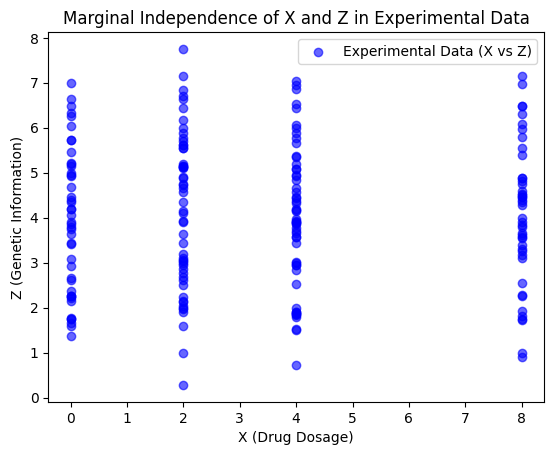

In [ ]:
# Your code here

import numpy as np
import matplotlib.pyplot as plt

# Plotting X vs Z in experimental data
plt.scatter(x_exp, z_exp, alpha=0.6, c='blue', label="Experimental Data (X vs Z)")
plt.xlabel('X (Drug Dosage)')
plt.ylabel('Z (Genetic Information)')
plt.title('Marginal Independence of X and Z in Experimental Data')
plt.legend()
plt.show()


In the experimental data, $X$ and $Z$ are independent because the intervention on $X$ breaks the dependency between them.

The scatter plot shows this independence by illustrating that $X$ and $Z$ do not exhibit any functional relationship after the intervention $do(X=x)$.

**Task 8 (2 points):** Now, we will use the method of inverse probability weighting (section 3.6 in the book, covered in lecture 12) for this task. Using *only the observational data*, fit a logistic regression to predict $X$ using $Z$ as a feature. From this logistic regression, extract an estimate of $P(X=x_i|Z=z_i)$ for each data point $(x_i, y_i, z_i)$. (Consult the scikit-learn manual to learn how to do this.) Use these to compute an inverse probability weight for each data point in the observational data set.

Important note: the purpose of the logistic regression is *not* to predict the value of $X$, because we already know that value for each data point! But we do need the logistic regression to esimate the probability $P(X=x_i|Z=z_i)$.

In [ ]:
# Create logistic regression object (using scikit-learn)
# reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here

import numpy as np
from sklearn.linear_model import LogisticRegression

# Step 1: Fit the logistic regression model
# Use Z as the feature to predict X
z_reshaped = z.reshape(-1, 1)  # Reshape Z to be a 2D array (required for scikit-learn)

# Create the logistic regression model
reg_logistic = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Fit the logistic regression model to predict X using Z
reg_logistic.fit(z_reshaped, x)

# Step 2: Get the predicted probabilities for P(X=xi | Z=zi)
# The logistic regression model will give probabilities for each class (X values: 0, 2, 4, 6, 8, 10)
predicted_probabilities = reg_logistic.predict_proba(z_reshaped)

# Step 3: Extract the probabilities corresponding to the actual X values in the dataset
# We need to access the probabilities of the actual classes (0, 2, 4, 6, 8, 10) for each data point
probabilities = np.array([predicted_probabilities[i, np.where(reg_logistic.classes_ == x[i])[0][0]] for i in range(len(x))])

# Step 4: Compute the inverse probability weights for each data point
ipw = 1 / probabilities

# Show the first few inverse probability weights as an example
print("Inverse probability weights (first 10 data points):", ipw[:10])


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Inverse probability weights (first 10 data points): [1.52433691 1.49220994 1.86172848 1.61057024 1.51944862 1.57027147
 1.76136434 1.48343319 1.61294679 1.51534089]


**Task 9 (1 point):** Now again predict $Y$ in terms of $X$ using only the observational data as training data, but this time weighting each data point with the inverse probability weight. (Machine learning libraries often provides a way to specify a weight for each data point when fitting a model to data; check the manual of the library you are using.) Plot your regression curve in the same plot as the experimental data, as before.

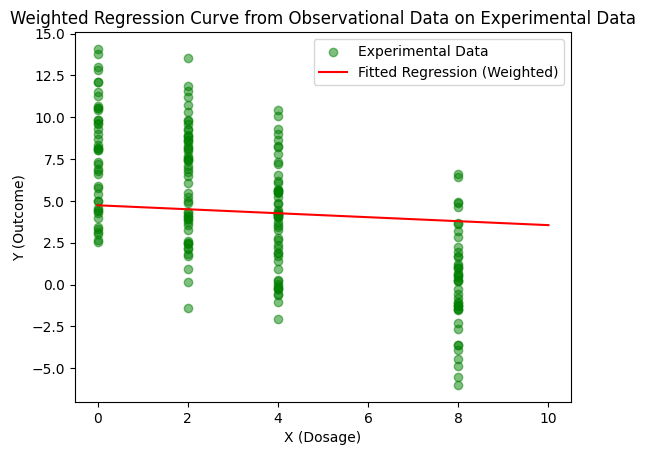

In [ ]:
# Your code here

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 1: Fit the weighted regression model
# Use x as the feature and y as the target
# Weights are the inverse probability weights (IPWs)
reg_weighted = LinearRegression()

# Fit the model using the IPWs as sample weights
reg_weighted.fit(x.reshape(-1, 1), y, sample_weight=ipw)

# Step 2: Create an array of x-values in the range [0, 10] for plotting the regression curve
x_range = np.linspace(0, 10, 100).reshape(-1, 1)

# Step 3: Predict the corresponding y-values using the trained weighted model
y_pred_weighted = reg_weighted.predict(x_range)

# Step 4: Plot the experimental data, and the fitted regression curve

# Plot the experimental data (x_exp, y_exp from previous task)
plt.scatter(x_exp, y_exp, label='Experimental Data', color='green', alpha=0.5)

# Plot the fitted regression curve from the observational data (weighted)
plt.plot(x_range, y_pred_weighted, color='red', label='Fitted Regression (Weighted)')

# Add labels and title
plt.xlabel('X (Dosage)')
plt.ylabel('Y (Outcome)')
plt.title('Weighted Regression Curve from Observational Data on Experimental Data')
plt.legend()

# Show the plot
plt.show()


**Task 10 (0.5 points):** To verify that these predictions of the causal effect of $X$ on $Y$ are more accurate, again compute the RMSE on the experimental data.

In [ ]:
# Your code here

from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Predict Y for the experimental data using the weighted regression model
# We already have the fitted weighted model 'reg_weighted'

y_pred_weighted_exp = reg_weighted.predict(x_exp.reshape(-1, 1))

# Step 2: Compute the RMSE (Root Mean Squared Error)
rmse_weighted = np.sqrt(mean_squared_error(y_exp, y_pred_weighted_exp))

# Output the RMSE
print(f"RMSE on experimental data (weighted regression): {rmse_weighted}")


RMSE on experimental data (weighted regression): 3.9827966164079815


---

You are almost done! Before handing in, make sure that the code you hand in works, and that all plots are shown. **Submit just one file per team.** Name the submitted file according to your and your collaborator's last name (`submitter_collaborator.ipynb`).